In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Markov Model

In [126]:
datain = pd.read_csv("datasets/csv1.csv")
datain['Date'] = pd.to_datetime(datain['Date'])
datalist = datain['Value'].to_numpy()
dsize = datalist.size
dsize

551

In [127]:
# discretize the state space
decimal = 1
observed_states = np.around((10**decimal)*datalist).astype("int64")
min_state, max_state = np.min(observed_states), np.max(observed_states)
n_states = (max_state - min_state + 1) + 1  # all the states in [min, max], plus 1 out-of-bound state
print(n_states)

182


In [128]:
def generate_right_markov(order=1):   # order = how far to go back (i.e. state t depends on state t-order)
    # count the transitions
    data_int = observed_states - min_state
    pre = data_int[:-order]
    post = data_int[order:]
    markov = np.zeros((n_states, n_states))
    for a,b in zip(pre,post):
        markov[a, b] += 1.
    
    # frequency matrix
    freq = np.copy(markov).astype('int64')
    
    # process last column (corresponds to the out-of-bound state)
    row_sums = np.sum(markov[:,:-1], axis=1, keepdims=True)    # sum of rows (leave out last column)
    for i in np.where(row_sums == 0.)[0]:
        markov[i][-1] = 1.
    
    markov = markov / np.sum(markov, axis=1, keepdims=True)    # normalize to keep sum of column = 1
    
    return markov, freq

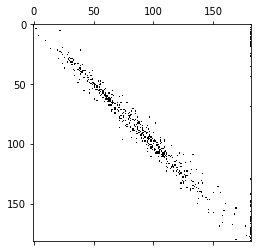

In [129]:
order = 1
markov, freq = generate_right_markov(order)
plt.spy(markov)

# Predict one point ahead from observed data & compare

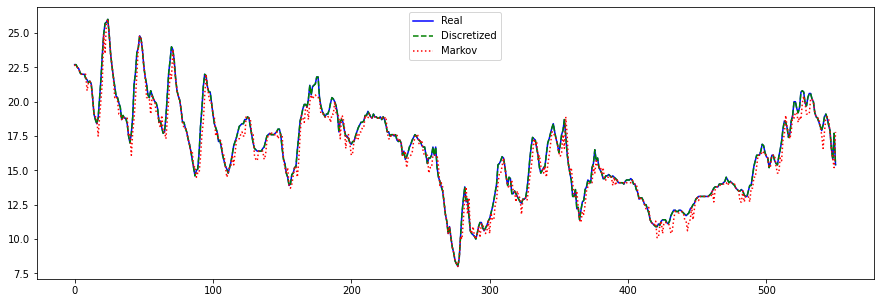

In [130]:
x_axis = np.arange(dsize)
predicted = observed_states[:order].tolist()

for x in x_axis[:-order]:
    # get the previous state from observed_states
    last_state = observed_states[x]
    next_state = np.argmax(markov[last_state - min_state]) + min_state
    # predict
    predicted.append(next_state)

plt.figure(figsize=(15,5))
plt.plot(x_axis, datalist, color="b", label="Real")
plt.plot(x_axis, observed_states / (10**decimal), color="g", linestyle="dashed", label="Discretized")
plt.plot(x_axis, np.array(predicted) / (10**decimal), color="r", linestyle="dotted", label="Markov")
plt.legend(loc=9)
plt.savefig("fig-markov-modeled.png")

# Random walks on Markov Graph

show one random walk in the future + its log-probability (not pure probability to avoid underflow)

In [131]:
def random_walk_weighted(n_steps):        # random walk but weighted
    log_prob = 0.
    rng = np.random.default_rng()
    state = observed_states[-1]
    future_states = [state]

    for i in range(n_steps):
        # weightes associated w/ each states
        weights = markov[state - min_state]
        # possible transitions are all states
        transitions = np.arange(len(weights))
        
        # select new state
        new_state = rng.choice(transitions, p=weights) + min_state
        # add to cumulative log-prob
        log_prob += np.log(markov[state-min_state, new_state-min_state])
        future_states.append(new_state)
        state = new_state
    
    return {'log_prob': log_prob, 'path': np.array(future_states) / (10**decimal)}

CPU times: total: 1min 8s
Wall time: 1min 8s


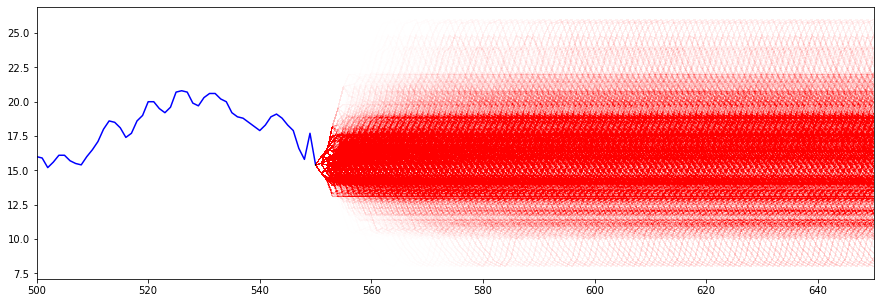

In [132]:
%%time
ahead = 100
future_x = np.arange(dsize-1, dsize + ahead)
myfig = plt.figure(figsize=(15,5))
plt.plot(x_axis, datalist, color="b")
# plt.plot(future_x, max_path['path'], color="r", linestyle='dotted')
for i in range(15000):
    walk = random_walk_weighted(ahead)
    plt.plot(future_x, walk['path'], color="r", linestyle='solid', alpha=0.002)
plt.xlim(500, 650)
# plt.ylim(0.5,4.0)
plt.savefig('markov-walk2.png')